# Dynamic Time Warping

Goal: To identify counties which are "further along the curve" and use them to assist in prediction of other counties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans

In [2]:
import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [3]:
deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
population = pd.read_csv("data/us/demographics/county_populations.csv")

### Los Angeles County vs. NYC County

In [8]:
la_fips = 6037
la_data = deaths.loc[deaths["fips"] == la_fips]
la_data.head()

,fips,date,county,state,cases,deaths
376,6037,2020-01-26,Los Angeles,California,1.0,0.0
377,6037,2020-01-27,Los Angeles,California,0.0,0.0
378,6037,2020-01-28,Los Angeles,California,0.0,0.0
379,6037,2020-01-29,Los Angeles,California,0.0,0.0
380,6037,2020-01-30,Los Angeles,California,0.0,0.0


In [9]:
ny_fips = 36061
ny_data = deaths.loc[deaths["fips"] == ny_fips]
ny_data.head()

,fips,date,county,state,cases,deaths
1823,36061,2020-03-01,New York City,New York,1.0,0.0
1824,36061,2020-03-02,New York City,New York,0.0,0.0
1825,36061,2020-03-03,New York City,New York,1.0,0.0
1826,36061,2020-03-04,New York City,New York,0.0,0.0
1827,36061,2020-03-05,New York City,New York,2.0,0.0


In [10]:
# Construct datasets: deaths as a proportion of population
la = {"dates": [], "deaths": []}
la_pop = int(population.loc[population["FIPS"] == la_fips]["total_pop"])
for idx, row in la_data.iterrows():
    la["dates"].append(row["date"])
    la["deaths"].append(row["deaths"] / la_pop)

ny = {"dates": [], "deaths": []}
ny_pop = int(population.loc[population["FIPS"] == ny_fips]["total_pop"])
for idx, row in la_data.iterrows():
    ny["dates"].append(row["date"])
    ny["deaths"].append(row["deaths"] / ny_pop)

In [11]:
distance, path = fastdtw(np.array(la["deaths"]), np.array(ny["deaths"]), dist=euclidean)
print(distance)
print(path)

0.00035985023758273234
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (20, 12), (21, 13), (22, 14), (23, 15), (24, 16), (25, 17), (26, 18), (27, 19), (28, 20), (29, 21), (30, 22), (31, 23), (32, 24), (33, 25), (34, 26), (35, 27), (36, 28), (37, 29), (38, 30), (39, 31), (40, 32), (41, 33), (42, 34), (43, 35), (44, 36), (45, 37), (46, 38), (47, 39), (48, 40), (49, 41), (50, 42), (51, 43), (52, 44), (53, 45), (54, 46), (54, 47), (54, 48), (54, 49), (55, 50), (56, 51), (57, 52), (58, 53), (59, 54), (60, 55), (61, 56), (62, 56), (63, 56), (64, 56), (65, 57), (66, 57), (67, 57), (68, 57), (69, 57), (70, 57), (71, 57), (72, 58), (73, 58), (74, 58), (75, 59), (76, 60), (77, 61), (77, 62), (78, 63), (79, 64), (80, 64), (81, 65), (82, 66), (83, 67), (83, 68), (83, 69), (83, 70), (83, 71), (83, 72), (83, 73), (83, 74), (83, 75), (83, 76), (83, 77), (83, 78), (83, 79), (83,

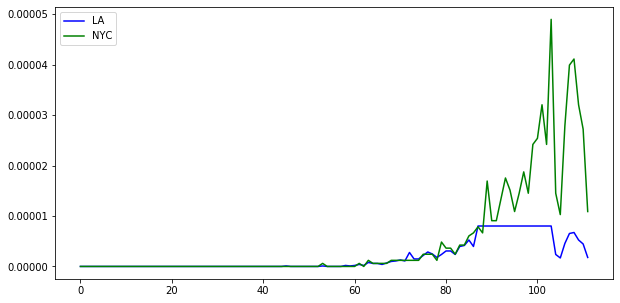

In [12]:
# Plot the warped data
overlay = {"dates": [], "la_deaths": [], "ny_deaths": []}
for (la_idx, ny_idx) in path:
    overlay["dates"].append(la["dates"][la_idx])
    overlay["la_deaths"].append(la["deaths"][la_idx])
    overlay["ny_deaths"].append(ny["deaths"][ny_idx])

plt.figure(figsize=(10, 5))
plt.plot(overlay["la_deaths"], label="LA", c="blue")
plt.plot(overlay["ny_deaths"], label="NYC", c="green")
plt.legend()
plt.show()

### Matching a Smaller Window

In [13]:
overlay_window = 14
test_per = 14
interval = 1

In [14]:
ny_df = pd.DataFrame(data=ny)
ny_start = ny_df.loc[ny_df["deaths"] > 5e-7].first_valid_index()
print(ny_start)

45


In [15]:
best_j, best_dist, best_path = 0, 1, []
i = len(la["dates"]) - overlay_window - test_per
for j in range(ny_start, len(ny["dates"]) - test_per, interval):
    distance, path = fastdtw(np.array(la["deaths"][i:i+overlay_window]), np.array(ny["deaths"][j:j+overlay_window]), dist=euclidean)
    if distance < best_dist:
        best_j = j
        best_dist = distance
        best_path = path

print(best_j)

51


In [16]:
# Align data by calculated indices
diff = i - best_j
overlay = pd.DataFrame(data = la)
overlay["ny"] = 0
overlay.tail()

,dates,deaths,ny
87,2020-04-22,0.000007,0
88,2020-04-23,0.000007,0
89,2020-04-24,0.000005,0
90,2020-04-25,0.000004,0
91,2020-04-26,0.000002,0


In [17]:
for i, row in overlay.iterrows():
    if i - diff >= 0 and i - diff < len(overlay["dates"]):
        overlay.loc[i, "ny"] = ny["deaths"][i - diff]

last_date = datetime.date.fromisoformat(overlay.iloc[-1]["dates"])
date = last_date
for i in range(diff):
    date += datetime.timedelta(days=1)
    overlay.loc[len(overlay)] = [date.isoformat(), 0, ny["deaths"][len(ny["deaths"]) - diff + i]]

overlay.tail()

,dates,deaths,ny
100,2020-05-05,0.0,0.000040
101,2020-05-06,0.0,0.000041
102,2020-05-07,0.0,0.000032
103,2020-05-08,0.0,0.000027
104,2020-05-09,0.0,0.000011


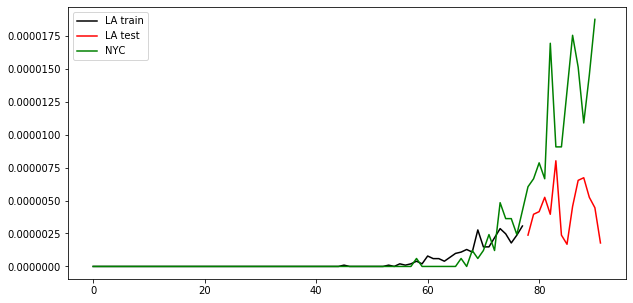

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(overlay["deaths"][:len(overlay["deaths"]) - test_per - diff], label="LA train", c="black")
plt.plot(overlay["deaths"][len(overlay["deaths"]) - test_per - diff:len(overlay["deaths"]) - diff], label="LA test", c="red")
plt.plot(overlay["ny"][:len(overlay["ny"]) - test_per], label="NYC", c="green")
plt.legend()
plt.show()

## Using DTW for Prediction

In [19]:
overlay.rename(columns={'dates': 'ds', 'deaths': 'y'}, inplace=True)

m = Prophet(seasonality_mode="multiplicative", interval_width = 0.68)
m.add_regressor("ny")
m.fit(overlay.iloc[:len(overlay) - diff - test_per])

In [20]:
future = pd.DataFrame()
future["ds"] = 0
future["ny"] = 0

d = last_date - datetime.timedelta(days=test_per)
for i in range(test_per):
    d += datetime.timedelta(days=1)
    try:
        idx = ny["dates"].index((d - datetime.timedelta(days=overlay_window)).isoformat())
        future.loc[len(future)] = [d.isoformat(), ny["deaths"][idx]]
    except ValueError as e:
        future.loc[len(future)] = [d.isoformat(), 0]
    
future.tail()

,ds,ny
9,2020-04-22,0.000018
10,2020-04-23,0.000015
11,2020-04-24,0.000011
12,2020-04-25,0.000015
13,2020-04-26,0.000019


In [21]:
pred = m.predict(future)

In [22]:
pred["yhat"] *= la_pop

In [23]:
la_plot = pd.DataFrame()
la_plot["date"] = 0
la_plot["deaths"] = 0

for i, row in la_data.iterrows():
    la_plot.loc[len(la_plot)] = [datetime.date.fromisoformat(row["date"]), row["deaths"]]
    
la_plot.tail()

,date,deaths
87,2020-04-22,66.0
88,2020-04-23,68.0
89,2020-04-24,53.0
90,2020-04-25,45.0
91,2020-04-26,18.0


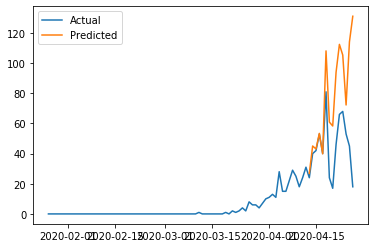

In [24]:
fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=la_plot, label="Actual")
ax.plot('ds', 'yhat', data=pred, label="Predicted")
plt.legend()
plt.show()

### Compared with Prophet On Its Own

In [368]:
m = Prophet(seasonality_mode="multiplicative", interval_width = 0.68)
m.fit(overlay.iloc[:len(overlay) - diff - test_per])

In [369]:
future = pd.DataFrame()
future["ds"] = 0
d = last_date - datetime.timedelta(days=test_per)
for i in range(test_per):
    d += datetime.timedelta(days=1)
    future.loc[len(future)] = [d.isoformat()]

future.tail()

,ds
9,2020-04-20
10,2020-04-21
11,2020-04-22
12,2020-04-23
13,2020-04-24


In [370]:
pred = m.predict(future)

In [371]:
pred["yhat"] *= la_pop

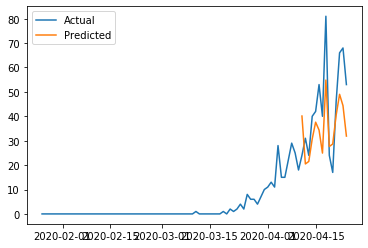

In [372]:
fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=la_plot, label="Actual")
ax.plot('ds', 'yhat', data=pred, label="Predicted")
plt.legend()
plt.show()

## Finding a Best-Fit County

In [70]:
fips_list = pd.read_csv("data/us/processing_data/fips_key.csv", encoding="cp1252")

In [24]:
best_j, best_fips, best_dist, best_path = 0, 0, 1, []
i = len(la["dates"]) - overlay_window - test_per

for idx, rw in fips_list.iterrows():
    try:
        county = int(rw["FIPS"])
        if (county == la_fips): continue
        print("County " + str(county) + "...", end='\r', flush=True)
        c_data = deaths.loc[deaths["fips"] == county]

        c = {"dates": [], "deaths": []}
        c_pop = int(population.loc[population["FIPS"] == county]["total_pop"])
        for idx, row in c_data.iterrows():
            c["dates"].append(row["date"])
            c["deaths"].append(row["deaths"] / c_pop)

        c_df = pd.DataFrame(data=c)
        c_start = c_df.loc[c_df["deaths"] > 5e-7].first_valid_index()
        if (c_start == None): continue

        for j in range(c_start, len(c["dates"]) - test_per, 1):
            if i - j < test_per: continue
            distance, path = fastdtw(np.array(la["deaths"][i:i+overlay_window]), np.array(c["deaths"][j:j+overlay_window]), dist=euclidean, radius=3)
            if distance < best_dist:
                best_j = j
                best_fips = county
                best_dist = distance
                best_path = path
                
    except TypeError as e:
        continue

print()
print(best_j)
print(best_fips)
print(best_dist)

NameError: name 'la' is not defined

In [45]:
best_data = deaths.loc[deaths["fips"] == best_fips]
best = {"dates": [], "deaths": []}
best_pop = int(population.loc[population["FIPS"] == best_fips]["total_pop"])

for idx, row in best_data.iterrows():
        best["dates"].append(row["date"])
        best["deaths"].append(row["deaths"] / c_pop)

best_df = pd.DataFrame(data=c)
best_start = best_df.loc[best_df["deaths"] > 5e-7].first_valid_index()

In [46]:
# Align data by calculated indices
diff = i - best_j
overlay = pd.DataFrame(data = la)
overlay["best_fit"] = 0
overlay["dates"]

0     2020-01-26
1     2020-01-27
2     2020-01-28
3     2020-01-29
4     2020-01-30
         ...    
87    2020-04-22
88    2020-04-23
89    2020-04-24
90    2020-04-25
91    2020-04-26
Name: dates, Length: 92, dtype: object

In [47]:
for i, row in overlay.iterrows():
    if i - diff >= 0 and i - diff < len(overlay["dates"]):
        overlay.loc[i, "best_fit"] = best["deaths"][i - diff]

last_date = datetime.date.fromisoformat(overlay.iloc[-1]["dates"])
date = last_date
for i in range(diff):
    date += datetime.timedelta(days=1)
    overlay.loc[len(overlay)] = [date.isoformat(), 0, best["deaths"][len(best["deaths"]) - diff + i]]

overlay.tail()

,dates,deaths,best_fit
141,2020-06-15,0.0,0.000984
142,2020-06-16,0.0,0.000703
143,2020-06-17,0.0,0.000984
144,2020-06-18,0.0,0.001124
145,2020-06-19,0.0,0.001265


In [48]:
overlay.rename(columns={'dates': 'ds', 'deaths': 'y'}, inplace=True)

m = Prophet(seasonality_mode="multiplicative", interval_width = 0.68)
m.add_regressor("best_fit")
m.fit(overlay.iloc[:len(overlay) - diff - test_per])

In [52]:
future = pd.DataFrame()
future["ds"] = 0
future["best_fit"] = 0

d = last_date - datetime.timedelta(days=test_per)
for i in range(test_per):
    d += datetime.timedelta(days=1)
    try:
        future.loc[len(future)] = [d.isoformat(), float(overlay.loc[overlay["ds"] == d.isoformat()]["best_fit"])]
    except ValueError as e:
        future.loc[len(future)] = [d.isoformat(), 0]
    
future.tail()

,ds,best_fit
9,2020-04-22,0.001967
10,2020-04-23,0.001546
11,2020-04-24,0.001546
12,2020-04-25,0.002248
13,2020-04-26,0.000843


In [53]:
pred = m.predict(future)
pred["yhat"] *= la_pop

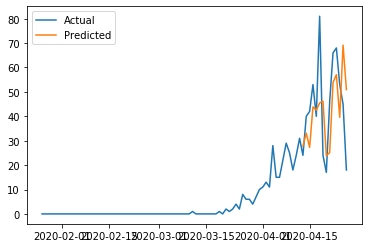

In [54]:
fig, ax = plt.subplots()
ax.plot('date', 'deaths', data=la_plot, label="Actual")
ax.plot('ds', 'yhat', data=pred, label="Predicted")
plt.legend()
plt.show()

In [55]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,best_fit,best_fit_lower,best_fit_upper,extra_regressors_multiplicative,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-04-13,0.000002,0.000003,0.000003,0.000002,0.000002,1.030914,1.030914,1.030914,1.030914,...,0.576996,0.576996,0.576996,-0.453918,-0.453918,-0.453918,0.0,0.0,0.0,27.854781
1,2020-04-14,0.000002,0.000003,0.000004,0.000002,0.000002,0.619077,0.619077,0.619077,0.619077,...,0.804187,0.804187,0.804187,0.185110,0.185110,0.185110,0.0,0.0,0.0,33.109453
2,2020-04-15,0.000002,0.000002,0.000003,0.000002,0.000002,0.516117,0.516117,0.516117,0.516117,...,0.433097,0.433097,0.433097,-0.083020,-0.083020,-0.083020,0.0,0.0,0.0,27.285766
3,2020-04-16,0.000002,0.000004,0.000005,0.000002,0.000002,0.927955,0.927955,0.927955,0.927955,...,1.221813,1.221813,1.221813,0.293858,0.293858,0.293858,0.0,0.0,0.0,43.831908
4,2020-04-17,0.000002,0.000004,0.000004,0.000002,0.000002,1.545711,1.545711,1.545711,1.545711,...,1.083194,1.083194,1.083194,-0.462517,-0.462517,-0.462517,0.0,0.0,0.0,42.531026


# Generating a Submission Using Dynamic Time Warping

In [40]:
class Covid_DTW:
    def __init__(self, death_df, population_df, fips_df, county_to_cluster, cluster_to_counties):
        """
        death_df should have columns fips, date, and deaths
        population_df should have columns fips, population
        fips_df should have coulumn fips
        """
        self.data = death_df
        self.pop = population_df
        self.fips = fips_df
        self.last_date = None
        self.co_cl = county_to_cluster
        self.cl_co = cluster_to_counties
        self.num_found_fit = 0
    
    def get_best_fit(self, target, target_county, dist_func, overlay_window, test_per, pred_per, death_lbound, log=True):        
        best_idx, best_fips, best_dist = -1, -1, float("inf")
        target_idx = len(target["dates"]) - overlay_window - test_per
        
        cluster = self.co_cl[str(target_county)]
        cluster_fips = self.cl_co[cluster]
        
        for county in cluster_fips:
            try: 
                if (county == target_county): continue

                if log: print("Testing best fit for " + str(target_county) + " on " + str(county) + "...", end='\r', flush=True)
                c_data = self.data.loc[self.data["fips"] == int(county)]

                c = {"dates": [], "deaths": []}
                c_pop = int(self.pop.loc[self.pop["fips"] == int(county)]["population"])
                cum_deaths = 0
                for idx, row in c_data.iterrows():
                    c["dates"].append(row["date"])
                    c["deaths"].append(row["deaths"] / c_pop)
                    cum_deaths += row["deaths"]

                #print(c["dates"])

                if cum_deaths <= death_lbound: continue

                c_df = pd.DataFrame(data=c)
                c_start = c_df.loc[c_df["deaths"] > 5e-6].first_valid_index()
                if (c_start == None): continue

                for j in range(c_start, len(c["dates"]) - test_per, 1):
                    if target_idx - j < pred_per + test_per: continue
                    distance, path = fastdtw(np.array(target["deaths"][target_idx:target_idx+overlay_window]), np.array(c["deaths"][j:j+overlay_window]), dist=dist_func)
                    if distance < best_dist:
                        best_idx = j
                        best_fips = county
                        best_dist = distance
                        best_path = path
                        
            except TypeError as e:
                continue
        
        return best_idx, int(best_fips), best_dist
    
    def predict_county(self, target_county, dist_func, fit_func, overlay_window, test_per, pred_per, death_lbound, log=True):
        if log: print("Predicting for county " + str(target_county) + "...                    ", end='\r', flush=True)
        
        target_data = self.data.loc[self.data["fips"] == target_county]
        try:
            target_pop = int(self.pop.loc[self.pop["fips"] == target_county]["population"])
        except TypeError as e:
            #print("No population found for", str(target_county))
            return fit_func(pd.DataFrame(data={"dates":[], "deaths":[]}), target_county, 0, test_per, pred_per, 0, datetime.date.fromisoformat('2020-04-26'), self)

        # Construct target dataset: deaths as a proportion of population
        target = {"dates": [], "deaths": []}
        deathcount = 0
        for idx, row in target_data.iterrows():
            target["dates"].append(row["date"])
            target["deaths"].append(row["deaths"] / target_pop)
            deathcount += row["deaths"]
        
        #print(str(len(target["dates"])) + "                                  ")
            
        target_idx = len(target["dates"]) - overlay_window - test_per
        
        if deathcount > death_lbound:
            best_idx, best_fips, best_dist = self.get_best_fit(target, target_county, dist_func, overlay_window, test_per, pred_per, death_lbound, log=log)
        else:
            best_idx, best_fips, best_dist = -1, -1, 100
        
        if best_fips >= 0 and best_dist < 1e-5:
            # Align data by calculated indices
            diff = target_idx - best_idx
            overlay = pd.DataFrame(data = target)
            overlay["best_fit"] = 0
            
            best_data = self.data.loc[self.data["fips"] == best_fips]
            best = {"dates": [], "deaths": []}
            best_pop = int(self.pop.loc[self.pop["fips"] == best_fips]["population"])
            for i, row in best_data.iterrows():
                best["dates"].append(row["date"])
                best["deaths"].append(row["deaths"] / best_pop)

            for i, row in overlay.iterrows():
                if i - diff >= 0 and i - diff < len(best["dates"]):
                    overlay.loc[i, "best_fit"] = best["deaths"][i - diff]

            if not self.last_date:
                self.last_date = datetime.date.fromisoformat(overlay.iloc[-1]["dates"])
            date = self.last_date
            for i in range(diff):
                date += datetime.timedelta(days=1)
                overlay.loc[len(overlay)] = [date.isoformat(), 0, best["deaths"][len(best["deaths"]) - diff + i]]
            
            self.num_found_fit += 1
            
            overlay["best_fit"] *= target_pop
            
        else:
            diff = 0
            overlay = pd.DataFrame(data = target)
            overlay["best_fit"] = -1
            
            if not self.last_date:
                try: self.last_date = datetime.date.fromisoformat(overlay.iloc[-1]["dates"])
                except Exception as e: self.last_date = datetime.date.fromisoformat('2020-04-26')
        
        overlay["deaths"] *= target_pop
        return fit_func(overlay, target_county, target_pop, test_per, pred_per, diff, self.last_date, self)
    
    def generate_submission(self, filename, fit_func, overlay_window, test_per, pred_per, death_lbound, dist_func=euclidean, log=True):
        ids, i10, i20, i30, i40, i50, i60, i70, i80, i90 = [], [], [], [], [], [], [], [], [], []
        
        for idx, row in self.fips.iterrows():
            county = int(row["fips"])
            this_id, this_10, this_20, this_30, this_40, this_50, this_60, this_70, this_80, this_90 = (
                self.predict_county(county, dist_func, fit_func, overlay_window, test_per, pred_per, death_lbound, log)
            )
            ids += this_id
            i10 += this_10
            i20 += this_20
            i30 += this_30
            i40 += this_40
            i50 += this_50
            i60 += this_60
            i70 += this_70
            i80 += this_80
            i90 += this_90
        
        predictions = pd.DataFrame(data={"id":ids, "10":i10, "20":i20, "30":i30, "40":i40, "50":i50, "60":i60, "70":i70, "80":i80, "90":i90})
        predictions.to_csv(filename, index=False)
        
        print("Used dynamic time warping to help predictions in", self.num_found_fit, "counties!          ")
        
        return predictions

In [41]:
def fit_prophet_from_overlay(overlay, county, pop, test_per, pred_per, diff, last_date, dtw_instance):
    overlay.rename(columns={'dates': 'ds', 'deaths': 'y'}, inplace=True)
    
    c_row = dtw_instance.data.loc[dtw_instance.data["fips"] == county]
    cum_deaths = 0
    for i, item in c_row.iterrows(): cum_deaths += int(item["deaths"])
        
    ids, i10, i20, i30, i40, i50, i60, i70, i80, i90 = [], [], [], [], [], [], [], [], [], []
    z_80 = 1.28
    z_60 = 0.84
    z_40 = 0.525
    z_20 = 0.25
    
    if cum_deaths > 15:
        try:
            overlay.fillna(0, inplace=True)
            m = Prophet(seasonality_mode="multiplicative", interval_width = 0.68)
            if int(overlay.loc[overlay["ds"] == last_date.isoformat()]["best_fit"]) >= 0:
                m.add_regressor("best_fit", prior_scale=1.0)
                #print("Added regressor for", str(county))

            m.fit(overlay.iloc[:len(overlay) - diff - test_per])

            future = pd.DataFrame()
            future["ds"] = 0
            future["best_fit"] = 0

            d = last_date - datetime.timedelta(days=test_per)
            for i in range(test_per + pred_per):
                d += datetime.timedelta(days=1)
                try:
                    future.loc[len(future)] = [d.isoformat(), float(overlay.loc[overlay["ds"] == d.isoformat()]["best_fit"])]
                except ValueError as e:
                    future.loc[len(future)] = [d.isoformat(), 0]

            forecast = m.predict(future)
            #forecast["yhat"] *= pop
            #forecast["yhat_upper"] *= pop
            #forecast["yhat_lower"] *= pop

            for i, pred in forecast.iterrows():
                date = pred["ds"]
                upper = pred["yhat_upper"]
                lower = pred["yhat_lower"]
                mid = pred["yhat"]
                sd = upper - mid

                this_id = str(date)[:10] + "-" + str(county)
                ids.append(this_id)
                i10.append(mid - sd * z_80)
                i20.append(mid - sd * z_60)
                i30.append(mid - sd * z_40)
                i40.append(mid - sd * z_20)
                i50.append(mid)
                i60.append(mid + sd * z_20)
                i70.append(mid + sd * z_40)
                i80.append(mid + sd * z_60)
                i90.append(mid + sd * z_80)
        
        # This county doesn't have enough historical data to train a model
        except ValueError as e:
            print("Not enough data for county", county, "                            ")
            d = last_date - datetime.timedelta(days=test_per)
            for i in range(test_per + pred_per):
                d += datetime.timedelta(days=1)
                this_id = d.isoformat() + "-" + str(county)
                ids.append(this_id)
                i10.append(0)
                i20.append(0)
                i30.append(0)
                i40.append(0)
                i50.append(0)
                i60.append(0)
                i70.append(0)
                i80.append(0)
                i90.append(0)
    
    else:
        d = last_date - datetime.timedelta(days=test_per)
        for i in range(test_per + pred_per):
            d += datetime.timedelta(days=1)
            this_id = d.isoformat() + "-" + str(county)
            ids.append(this_id)
            i10.append(0)
            i20.append(0)
            i30.append(0)
            i40.append(0)
            i50.append(0)
            i60.append(0)
            i70.append(0)
            i80.append(0)
            i90.append(0)
    
    return ids, i10, i20, i30, i40, i50, i60, i70, i80, i90
        

In [42]:
def cluster_counties(num_clusters):
    county_data = pd.read_csv("data/us/demographics/county_land_areas.csv", encoding="cp1252", dtype={"County FIPS": str})

    cluster_to_counties = {}
    county_to_cluster = {}

    km = KMeans(n_clusters=num_clusters)
    km = km.fit(county_data[["2010 Density per square mile of land area - Population", "2010 Density per square mile of land area - Housing units"]])
    county_data.loc[:, "cluster"] = km.labels_

    for i, row in county_data.iterrows():
        fips = row["County FIPS"]
        cluster = row["cluster"]

        if cluster in cluster_to_counties:
            cluster_to_counties[cluster].append(fips)
        else:
            cluster_to_counties[cluster] = [fips]

        county_to_cluster[fips] = cluster

    return county_to_cluster, cluster_to_counties

### Using the Covid_DTW class and Prophet fit function to make a submission

In [43]:
deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
population = pd.read_csv("data/us/demographics/county_populations.csv")
fips_list = pd.read_csv("data/us/processing_data/fips_key.csv", encoding="cp1252")

population.rename(columns={"FIPS": "fips", "total_pop": "population"}, inplace=True)
fips_list.rename(columns={"FIPS": "fips"}, inplace=True)

In [44]:
county_to_cluster, cluster_to_counties = cluster_counties(num_clusters=12)
model = Covid_DTW(deaths, population, fips_list, county_to_cluster, cluster_to_counties)

In [45]:
print(str(datetime.datetime.now()) + "\n\n")
output = model.generate_submission(filename="test_submissions/dtw_prophet.csv", fit_func=fit_prophet_from_overlay, overlay_window=14, test_per=14, pred_per=0, death_lbound=15)
print("\n\n" + str(datetime.datetime.now()))

2020-05-06 19:24:39.358758


Used dynamic time warping to help predictions in 36 counties!          


2020-05-06 20:27:22.076229


In [46]:
output["10"] = output["10"].apply(lambda x: x if x >= 1 else 0)
output["20"] = output["20"].apply(lambda x: x if x >= 1 else 0)
output["30"] = output["30"].apply(lambda x: x if x >= 1 else 0)
output["40"] = output["40"].apply(lambda x: x if x >= 1 else 0)
output["50"] = output["50"].apply(lambda x: x if x >= 1 else 0)
output["60"] = output["60"].apply(lambda x: x if x >= 1 else 0)
output["70"] = output["70"].apply(lambda x: x if x >= 1 else 0)
output["80"] = output["80"].apply(lambda x: x if x >= 1 else 0)
output["90"] = output["90"].apply(lambda x: x if x >= 1 else 0)

In [47]:
output.to_csv("test_submissions/dtw_prophet.csv", index=False)

### Evaluate Performance

In [10]:
# Author: Jake Will 
#
# A script that allows us to locally evaluate our model's performance

import pandas as pd
import numpy as np

# Requires two NumPy arrays as input, the truth in y_true and predictions in y_pred. 
# The quantile should be a number between 0 and 1. I copied this code from the
# piazza post describing how to compute the pinball loss.
def pinball_loss(y_true, y_pred, quantile = 0.5):
    delta = y_true - y_pred
    # Compute loss for underestimates. 
    loss_above = np.sum(delta[delta > 0]) * (quantile)
    # Compute loss for overestimates.
    loss_below = np.sum(-1 * delta[delta < 0]) * (1 - quantile)
    return (loss_above + loss_below) / len(y_true)

# Input the name of the submission file to evaluate here
submission_file = "Epidemiological Models/delphi_test.csv"

# Input the desired dates into these lists - both lists
# need to be updated because the files have different
# date formats

nyt_dates = ['5/8/20', '5/9/20', '5/10/20', '5/11/20', '5/12/20', '5/13/20', '5/14/20', '5/15/20', '5/16/20', '5/17/20', '5/18/20', '5/19/20', '5/20/20', '5/21/20']
submission_dates = ["2020-05-08", "2020-05-09", "2020-05-10", "2020-05-11", "2020-05-12", "2020-05-13", "2020-05-14", "2020-05-15", "2020-05-16", "2020-05-17", "2020-05-18", "2020-05-19", "2020-05-20", "2020-05-21"]

# Because the files use different date formats, we'll use a map to
# be able to easily get the nyt dates from the submission dates.
# If things get significantly more complicated as the project
# continues, we might consider using a date-time library, but for
# now this should be sufficient.

submission_to_nyt_date = {}
for i, date in enumerate(submission_dates):
    submission_to_nyt_date[date] = nyt_dates[i]

# Compute the submission predictions
submission = pd.read_csv(submission_file)
submission = submission[submission['id'].str.contains(('|'.join(submission_dates)))]

# Compute the actual results
deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
deaths = deaths[['date', 'fips', 'deaths']]
deaths = deaths[deaths['date'].str.contains(('|'.join(submission_dates)))]

# Generate a numpy array of the actual results in the same order
# as the submission. If a county has no reported deaths, we assume
# that is has 0.

truth = np.empty(len(submission['id'].values))
for i, submission_id in enumerate(submission['id'].values):
    split_id = submission_id.split('-')
    # Extract the FIPS and date from the id column of the submission
    FIPS = int(split_id[-1])
    date = '-'.join(split_id[:-1])

    # Extract the relevant row of the nyt deaths data
    df = deaths.loc[(deaths['fips'] == FIPS) & (deaths['date'] == date)]

    # Set the truth numpy array accordingly
    if df.empty:
        truth[i] = 0
    else:
        truth[i] = df['deaths']

# Compute the pinball score using the given dates, submission, and
# truth values
score = 0.0
for column in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    score = score + pinball_loss(truth, submission[str(column)].values, quantile = column / 100.0)

score = score/9.0

print(score)

0.1639696440535227


All 0's loss: ~0.32 \
Prophet alone loss: 0.2645782822355685 \
Best prophet w/ DTW loss: 0.27197204421592697

8 clusters ->  \
12 clusters -> 0.27197204421592697 (DTW used for 36 counties) \
16 clusters -> 

No best distance minimum: 0.30582484582644276 \
With minimum: 0.2816424073220742

## Comparing Performance on Individual Counties With and Without DTW

In [49]:
deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
population = pd.read_csv("data/us/demographics/county_populations.csv")
fips_list = pd.read_csv("data/us/processing_data/fips_key.csv", encoding="cp1252")

population.rename(columns={"FIPS": "fips", "total_pop": "population"}, inplace=True)
fips_list.rename(columns={"FIPS": "fips"}, inplace=True)

county_to_cluster, cluster_to_counties = cluster_counties(num_clusters=12)
model = Covid_DTW(deaths, population, fips_list, county_to_cluster, cluster_to_counties)

In [50]:
def score_one_county(submission):
    nyt_dates = ['4/22/20', '4/23/20', '4/24/20', '4/25/20', '4/26/20', '4/27/20', '4/28/20', '4/29/20', '4/30/20', '5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20']
    submission_dates = ['2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05']

    submission_to_nyt_date = {}
    for i, date in enumerate(submission_dates):
        submission_to_nyt_date[date] = nyt_dates[i]

    # Compute the submission predictions
    submission = submission[submission['id'].str.contains(('|'.join(submission_dates)))]

    # Compute the actual results
    deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
    deaths = deaths[['date', 'fips', 'deaths']]
    deaths = deaths[deaths['date'].str.contains(('|'.join(submission_dates)))]

    # Generate a numpy array of the actual results in the same order
    # as the submission. If a county has no reported deaths, we assume
    # that is has 0.

    truth = np.empty(len(submission['id'].values))
    for i, submission_id in enumerate(submission['id'].values):
        split_id = submission_id.split('-')
        # Extract the FIPS and date from the id column of the submission
        FIPS = int(split_id[-1])
        date = '-'.join(split_id[:-1])

        # Extract the relevant row of the nyt deaths data
        df = deaths.loc[(deaths['fips'] == FIPS) & (deaths['date'] == date)]

        # Set the truth numpy array accordingly
        if df.empty:
            truth[i] = 0
        else:
            truth[i] = df['deaths']

    # Compute the pinball score using the given dates, submission, and
    # truth values
    score = 0.0
    for column in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
        score = score + pinball_loss(truth, submission[str(column)].values, quantile = column / 100.0)

    score = score/9.0

    return score

In [54]:
overlay_window = 14
test_per = 14
pred_per = 0

for idx, row in fips_list.iterrows():
    target_county = row["fips"]
    name = row["COUNTY"]
    
    target_data = model.data.loc[model.data["fips"] == target_county]
    try:
        target_pop = int(model.pop.loc[model.pop["fips"] == target_county]["population"])
    except TypeError as e:
        continue

    # Construct target dataset: deaths as a proportion of population
    target = {"dates": [], "deaths": []}
    deathcount = 0
    for idx, row in target_data.iterrows():
        target["dates"].append(row["date"])
        target["deaths"].append(row["deaths"] / target_pop)
        deathcount += row["deaths"]

    target_idx = len(target["dates"]) - overlay_window - test_per

    if deathcount > 15:
        best_idx, best_fips, best_dist = model.get_best_fit(target, target_county, euclidean, overlay_window, test_per, pred_per, 15, log=False)
    else:
        best_idx, best_fips, best_dist = -1, -1, 100        
    
    if best_fips >= 0 and best_dist < 1e-5:
        print("Fit found for", str(target_county), name, "with", deathcount, "cumulative deaths.")
        
        # Align data by calculated indices
        diff = target_idx - best_idx
        overlay = pd.DataFrame(data = target)
        overlay["best_fit"] = 0

        best_data = model.data.loc[model.data["fips"] == best_fips]
        best = {"dates": [], "deaths": []}
        best_pop = int(model.pop.loc[model.pop["fips"] == best_fips]["population"])
        for i, row in best_data.iterrows():
            best["dates"].append(row["date"])
            best["deaths"].append(row["deaths"] / best_pop)

        for i, row in overlay.iterrows():
            if i - diff >= 0 and i - diff < len(best["dates"]):
                overlay.loc[i, "best_fit"] = best["deaths"][i - diff]

        if not model.last_date:
            model.last_date = datetime.date.fromisoformat(overlay.iloc[-1]["dates"])
        date = model.last_date
        for i in range(diff):
            date += datetime.timedelta(days=1)
            overlay.loc[len(overlay)] = [date.isoformat(), 0, best["deaths"][len(best["deaths"]) - diff + i]]
        
        overlay["best_fit"] *= target_pop
        overlay["deaths"] *= target_pop
        
        ids, i10, i20, i30, i40, i50, i60, i70, i80, i90 = fit_prophet_from_overlay(overlay, target_county, target_pop, test_per, pred_per, diff, model.last_date, model)
        dtw_pred = pd.DataFrame(data={"id":ids, "10":i10, "20":i20, "30":i30, "40":i40, "50":i50, "60":i60, "70":i70, "80":i80, "90":i90})
        
        overlay["best_fit"] = -1
        
        ids, i10, i20, i30, i40, i50, i60, i70, i80, i90 = fit_prophet_from_overlay(overlay, target_county, target_pop, test_per, pred_per, diff, model.last_date, model)
        nodtw_pred = pd.DataFrame(data={"id":ids, "10":i10, "20":i20, "30":i30, "40":i40, "50":i50, "60":i60, "70":i70, "80":i80, "90":i90})

        # Evaluate
        dtw_score = score_one_county(dtw_pred)
        print("Loss was", dtw_score, "with time warping.")
        nodtw_score = score_one_county(nodtw_pred)
        print("Loss was", nodtw_score, "without time warping.")
        print()

Fit found for 6013 Contra Costa County with 29.0 cumulative deaths.
Loss was 0.49796192481326834 with time warping.
Loss was 0.48727734853418664 without time warping.

Fit found for 6067 Sacramento County with 47.0 cumulative deaths.
Loss was 0.893638078956211 with time warping.
Loss was 0.8194848105840316 without time warping.

Fit found for 6073 San Diego County with 172.0 cumulative deaths.
Loss was 2.4525351307998986 with time warping.
Loss was 2.4967748650742356 without time warping.

Fit found for 6077 San Joaquin County with 26.0 cumulative deaths.
Loss was 0.7543829835516382 with time warping.
Loss was 0.36784657213584393 without time warping.

Fit found for 6081 San Mateo County with 53.0 cumulative deaths.
Loss was 2.1788193882264166 with time warping.
Loss was 0.8526522066057773 without time warping.

Fit found for 6085 Santa Clara County with 122.0 cumulative deaths.
Loss was 0.6982746872505681 with time warping.
Loss was 0.6355068493472905 without time warping.

Fit found 